# Exercise

### Acquire, Prepare, & Explore

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")
import acquire as a

In [2]:
# Changing these too often to do a .py import.

def split_data(df, target):
    '''
    take in a DataFrame and return train, validate, and test DataFrames; stratify on a specified variable.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=0.2, random_state=123, stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=123, stratify=train_validate[target])
    print(f'train: {len(train)} ({round(len(train)/len(df), 2)*100}% of {len(df)})')
    print(f'validate: {len(validate)} ({round(len(validate)/len(df), 2)*100}% of {len(df)})')
    print(f'test: {len(test)} ({round(len(test)/len(df), 2)*100}% of {len(df)})')
    return train, validate, test

    
def prep_titanic(df):
    '''
    This function will drop any duplicate observations, 
    drop ['deck', 'embarked', 'class', 'age'], fill missing embark_town with 'Southampton'
    and create dummy vars from sex and embark_town. 
    '''
    df = df.drop_duplicates()
    dummy_df = pd.get_dummies(df['sex'], drop_first=True, dtype='int')
    df = pd.concat([df, dummy_df], axis=1)
    df['embark_town'] = df['embark_town'].fillna(value='Southampton')
    dummy_df = pd.get_dummies(df['embark_town'], drop_first=False, dtype='int')
    df = pd.concat([df, dummy_df], axis=1)
    df = df.drop(columns=['pclass', 'deck', 'embarked', 'class', 'age', 'sex', 'embark_town', 'passenger_id'])

    return df

In [3]:
titanic = a.get_titanic_data()

titanic = prep_titanic(titanic)

print(titanic.shape)

(891, 9)


In [4]:
train, validate, test = split_data(titanic, 'survived')

train: 498 (56.00000000000001% of 891)
validate: 214 (24.0% of 891)
test: 179 (20.0% of 891)


In [5]:
X_train = train.drop(columns=["survived"])
y_train = train.survived

X_validate = validate.drop(columns=["survived"])
y_validate = validate.survived

X_test = test.drop(columns=["survived"])
y_test = test.survived

### 1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.



In [6]:
# Find baseline
y_train.mode()

# Establish baseline
baseline = y_train.mode()

# Create Baseline accuracy
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline prediction: {baseline[0]}")
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline prediction: 0
Baseline accuracy: 0.62


In [7]:
# Make the model
forest1 = RandomForestClassifier(max_depth=10, random_state=123, min_samples_leaf=1)

# Fit the model (on train and only train)
forest1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = forest1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of depth 10")
pd.DataFrame(report)

Tree of depth 10


,0,1,accuracy,macro avg,weighted avg
precision,0.926154,0.965318,0.939759,0.945736,0.941175
recall,0.980456,0.874346,0.939759,0.927401,0.939759
f1-score,0.952532,0.917582,0.939759,0.935057,0.939127
support,307.000000,191.000000,0.939759,498.000000,498.000000


### 2. Evaluate your results using the model score, confusion matrix, and classification report.



In [8]:
# Confusion atrix
cm = confusion_matrix(y_train, y_predictions)
print(cm)

[[301   6]
 [ 24 167]]


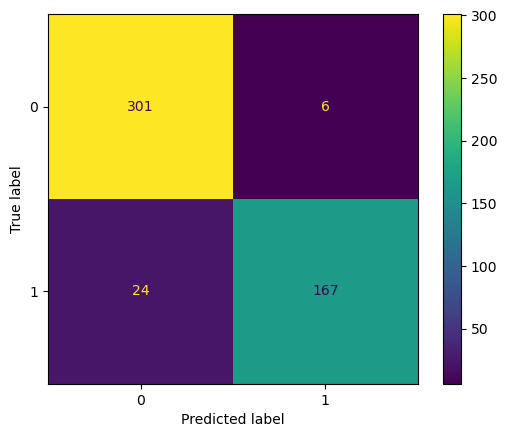

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest1.classes_)

disp.plot()
plt.show()

In [10]:
TN, FP, FN, TP = confusion_matrix(y_train,y_predictions).ravel()

TP, TN, FP, FN

(167, 301, 6, 24)

### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.



In [11]:
def calculate_metrics(TP, FP, FN, TN):
    '''
    Calculate various classification metrics given true positives, false positives, false negatives, and true negatives.
    '''
    ALL = TP + FP + FN + TN
    acc = (TP + TN) / ALL
    TPR = recall = TP / (TP + FN)
    FPR = FP / (FP + TN)
    TNR = TN / (TN + FP)
    FNR = FN / (FN + TP)
    precision = TP / (TP + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)
    support_pos = TP + FN
    support_neg = FP + TN
    
    metrics_dict = {
    'accuracy': acc,
    'recall': recall,
    'true_positive_rate': TPR,
    'false_positive_rate': FPR,
    'true_negative_rate': TNR,
    'false_negative_rate': FNR,
    'precision': precision,
    'f1_score': f1_score,
    'support_positive': support_pos,
    'support_negative': support_neg}
    
    metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['value'])
    
    return metrics_df

In [12]:
metrics1 = calculate_metrics(TP, FP, FN, TN)

print(metrics1)

                          value
accuracy               0.939759
recall                 0.874346
true_positive_rate     0.874346
false_positive_rate    0.019544
true_negative_rate     0.980456
false_negative_rate    0.125654
precision              0.965318
f1_score               0.917582
support_positive     191.000000
support_negative     307.000000


### 4. Run through steps increasing your min_samples_leaf and decreasing your max_depth.



In [13]:
stats = []
max_depth = 10

for i in range(2, max_depth):
    # Make model
    depth = max_depth - i
    n_samples = i
    ForestGump = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit model
    ForestGump = ForestGump.fit(X_train, y_train)

    # Evaluate model
    in_samp_acc = ForestGump.score(X_train, y_train)
    
    out_of_samp_acc = ForestGump.score(X_validate, y_validate)

    output = {"min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_samp_acc,
        "validate_accuracy": out_of_samp_acc}
    
    stats.append(output)
    
df = pd.DataFrame(stats)
df["difference"] = df.train_accuracy - df.validate_accuracy
df.style.highlight_max(color='blue', subset=pd.IndexSlice[:, 'validate_accuracy':'validate_accuracy'])

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,8,0.885542,0.775701,0.109841
1,3,7,0.861446,0.799065,0.062380
2,4,6,0.829317,0.780374,0.048943
3,5,5,0.823293,0.771028,0.052265
4,6,4,0.825301,0.766355,0.058946
5,7,3,0.817269,0.766355,0.050914
6,8,2,0.803213,0.766355,0.036858
7,9,1,0.755020,0.747664,0.007357


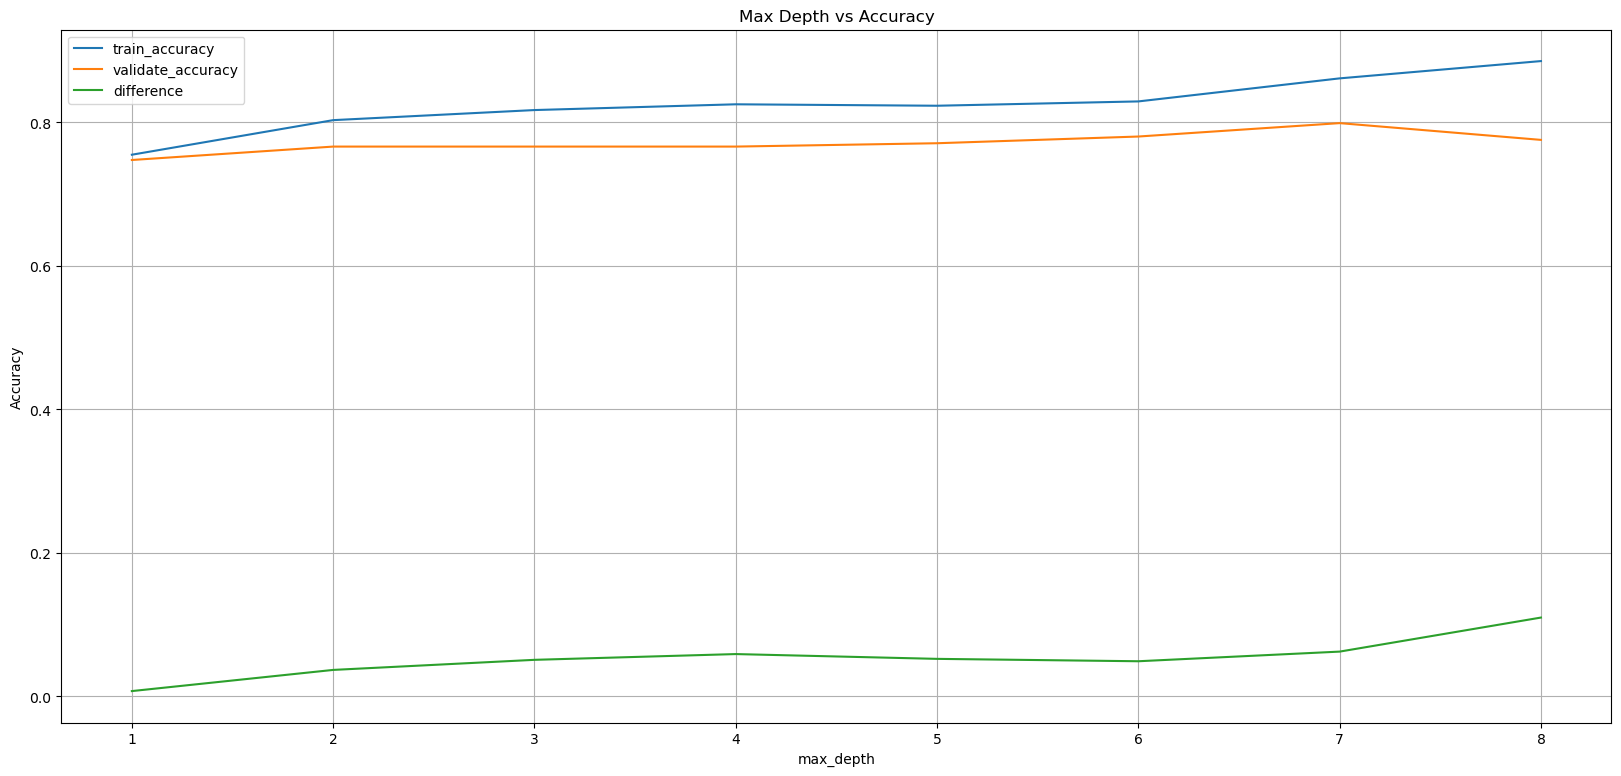

In [14]:
df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (20,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(1,9,1))
plt.title('Max Depth vs Accuracy')
plt.grid()

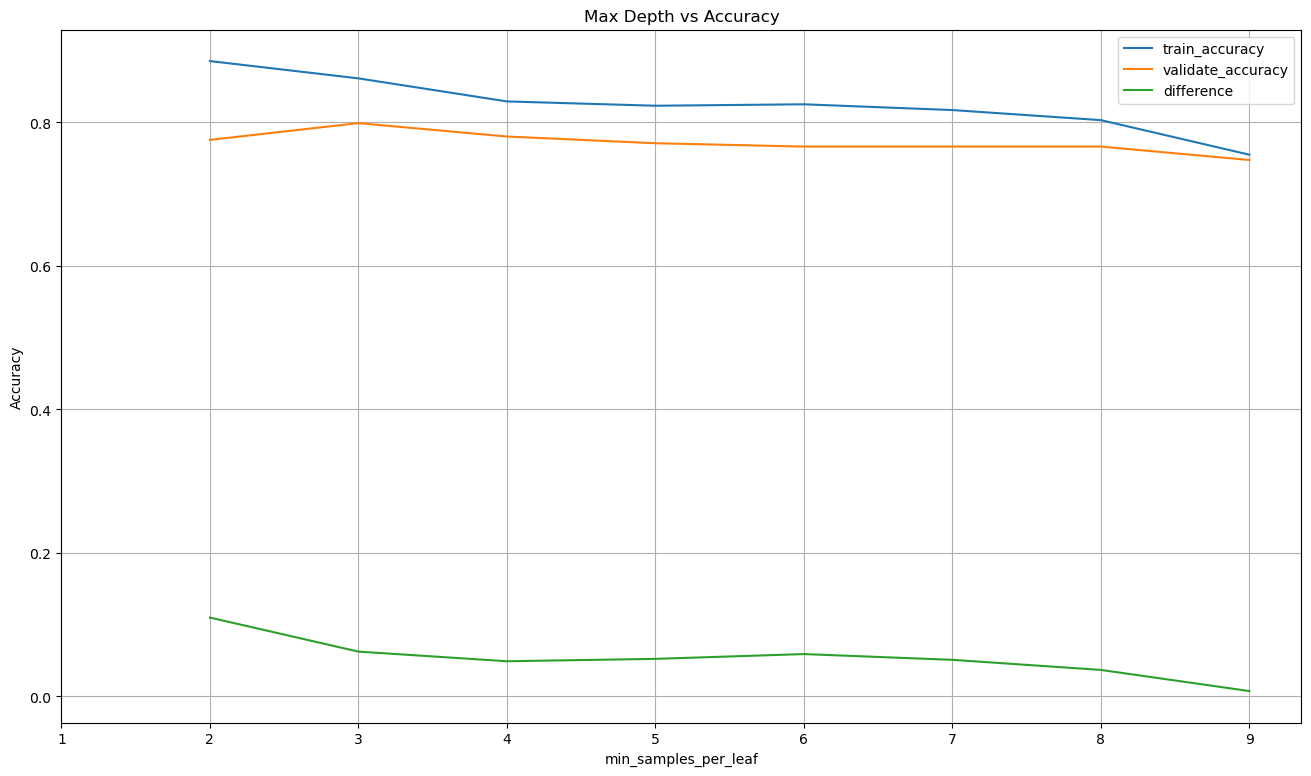

In [15]:
df.set_index('min_samples_per_leaf')[['train_accuracy', 'validate_accuracy', 'difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(1,10,1))
plt.title('Max Depth vs Accuracy')
plt.grid()

### 5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [14]:
# The highest validate accuracy is 3 leaf with a depth of 7. 
# This seems like the best bet to avoid overfitting the data.

# Notes

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# create a random forest classifier
rfc = RandomForestClassifier()

# specify the range of values for min_samples_leaf
param_grid = {'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# perform a grid search over the range of values
grid_search = GridSearchCV(rfc, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print('Best value for min_samples_leaf:', grid_search.best_params_['min_samples_leaf'])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# create a random forest classifier
rfc = RandomForestClassifier()

# specify the range of values for max_depth
param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# perform a grid search over the range of values
grid_search = GridSearchCV(rfc, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print('Best value for max_depth:', grid_search.best_params_['max_depth'])

## 1. Imports & Data

In [18]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from pydataset import data

## 1. Clean, explore, & split

In [19]:
# read Iris data from pydatset
df = data('iris')

# convert column names to lowercase, replace '.' in column names with '_'
df.columns = [col.lower().replace('.', '_') for col in df]

df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


### Split

In [20]:
from sklearn.model_selection import train_test_split

def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

## 2. Train Model

In [21]:
# split into train, validate, test
train, validate, test = train_validate_test_split(df, target='species', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['species'])
y_train = train.species

X_validate = validate.drop(columns=['species'])
y_validate = validate.species

X_test = test.drop(columns=['species'])
y_test = test.species

### Create Object

In [22]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

### Fit Model

In [23]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

### Feature Importance

In [24]:
print(rf.feature_importances_)

[0.08209193 0.02845967 0.47781398 0.41163442]


### Make Predictions

In [25]:
y_pred = rf.predict(X_train)

### Estimate Probability

In [26]:
y_pred_proba = rf.predict_proba(X_train)

## 3. Evaluate Model

### Compute Accuracy

In [27]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.98


### Confusion Matrix

In [28]:
print(confusion_matrix(y_train, y_pred))

[[28  0  0]
 [ 0 26  2]
 [ 0  0 28]]


### Classification Report

In [29]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        28
  versicolor       1.00      0.93      0.96        28
   virginica       0.93      1.00      0.97        28

    accuracy                           0.98        84
   macro avg       0.98      0.98      0.98        84
weighted avg       0.98      0.98      0.98        84



In [30]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.97


## 4. Validate Model

In [31]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.97
